In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import tensorflow as tf
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
with open("/kaggle/input/ships-in-satellite-imagery/shipsnet.json") as file:
    data = json.load(file)

In [3]:
ship_data = pd.DataFrame(data)
ship_data.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


<Axes: title={'center': 'Label Distribution'}, xlabel='labels'>

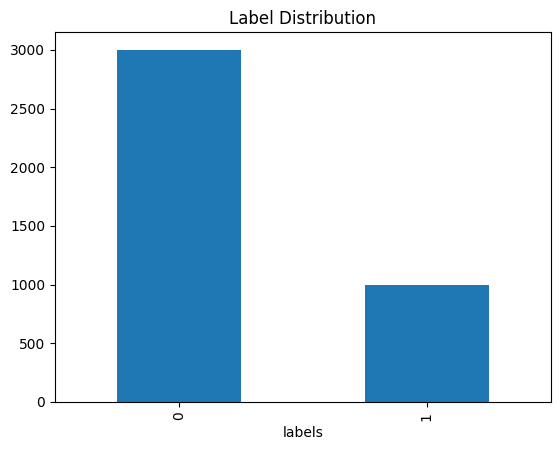

In [4]:
import matplotlib.pyplot as plt

ship_data["labels"].value_counts().plot(kind="bar", title="Label Distribution")

In [12]:
len(ship_data["data"])

4000

In [13]:
len(ship_data["data"][0])

19200

In [5]:
num_examples = len(ship_data["data"])
len_data = len(ship_data["data"][0])

X = np.zeros((num_examples, len_data), dtype="uint8")

for index in range(num_examples):
    X[index, :] = np.array(ship_data["data"][index]).astype(dtype="uint8")

X = X.reshape(-1, 80, 80, 3)

In [6]:
X.shape

(4000, 80, 80, 3)

In [7]:
y = ship_data["labels"].copy()

In [8]:
y = np.array(y)

In [9]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
y.shape

(4000,)

In [13]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1, stratify=y_train_full)

In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [19]:
from functools import partial

RegularizedConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, kernel_initializer="he_normal", padding="same", activation="relu")

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=[80, 80, 3]),
        RegularizedConv2D(filters=32),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.RandomCrop(height=70, width=70),
        RegularizedConv2D(filters=64),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.RandomZoom(height_factor=.2),
        RegularizedConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        RegularizedConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        RegularizedConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 80, 80, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_crop_1 (RandomCrop)           │ (None, 70, 70, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 70, 70, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 35, 35, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 35, 35, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         262,2

 Total params: 1,246,145 (4.75 MB)

 Trainable params: 1,244,481 (4.75 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [21]:
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics= ["accuracy"])
early_cb = tf.keras.callbacks.EarlyStopping(patience=15)

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_cb], epochs=30)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 810ms/step - accuracy: 0.7802 - loss: 0.4758 - val_accuracy: 0.8333 - val_loss: 0.3972
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.9495 - loss: 0.1448 - val_accuracy: 0.9528 - val_loss: 0.1219
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 814ms/step - accuracy: 0.9602 - loss: 0.1018 - val_accuracy: 0.9306 - val_loss: 0.2021
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 796ms/step - accuracy: 0.9756 - loss: 0.0821 - val_accuracy: 0.9639 - val_loss: 0.1030
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 801ms/step - accuracy: 0.9807 - loss: 0.0562 - val_accuracy: 0.9722 - val_loss: 0.0809
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.9773 - loss: 0.0695 - val_accuracy: 0.9667 - val_loss: 0.1039
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 793ms/step - accuracy: 0.9846 - loss: 0.0533 - val_accuracy: 0.9583 - val_loss: 0.1084
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 787ms/step - accuracy: 0.9740 - loss: 0

In [23]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9924 - loss: 0.0261


[0.03411858156323433, 0.987500011920929]

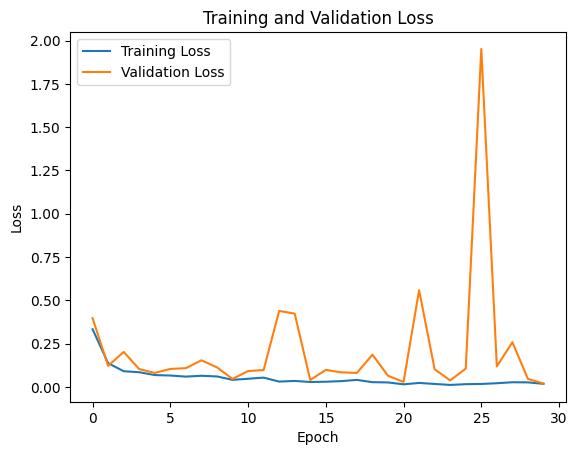

In [26]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label= "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()